# Chapter 20 - Blankenbach - Case1a

This notebook implements the Blankenbacch Case1a isoviscous thermal convection benchmark.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [12]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [13]:
function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 1000.
    end
end

initial_conditions! (generic function with 1 method)

## Model setup

Boundary conditions are insulating on the sides, fixed temperature top and bottom.

Initial condition is:
$$
T(x,y) = T_{surf} + \frac{(T_{btm}-T_{surf})}{H} y + dT\cos(\frac{\pi x}{W}) \sin(\frac{\pi y}{H})
$$

Note that the origin of the coordinate system is in the upper right. $y$ increases downward, $x$ increases rightward.

In [15]:
function blankenbach_initial_conditions!(markers::Markers,Ttop,Tbtm,W,H)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        # T(x,y) = Tsurf + (Tbtm-Tsurf)/H * y + dT*cos(pi*x/W)
        markers.scalars[eta,i] = 1e23
        markers.scalars[T,i] = Ttop + (Tbtm-Ttop)/H*my + 100.0*cos(pi*mx/W)*sin(pi*my/H)
    end
end

function compute_nusselt(grid::CartesianGrid,T,Tbcval,kThermal)
    
end

function run_blankenbach_case1a(nstep=1)
    nx = 257
    ny = 257
    W = 1e6
    H = 1e6
    
    gx = 0.0
    gy = 10.0
    alpha = 2.5e-5; # thermal expansivity

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    Tbcval = [0.,0.,273.,1273.]   
    
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 100e6*seconds_in_year # plot interval in seconds
    end_time = 1e9*seconds_in_year
    dtmax = plot_interval
    
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time blankenbach_initial_conditions!(markers,Tbcval[3],Tbcval[4],W,H)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 5.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0

    local rho
    local eta_s
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast
    
    nu_values=zeros(0)
    time_values=zeros(0)
    
    output_dir = "case1a"
    for itime in 1:nstep
        rho_var = markers.scalarFields["rho"]
        T_var = markers.scalarFields["T"]
        for i in 1:markers.nmark
            markers.scalars[rho_var,i] = 4000.0*(1.0-alpha*(markers.scalars[T_var,i]-Tbcval[3]))
        end
        
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);

        if time > 0.0
            nanind = findall(isnan.(rho_new))
            rho_new[nanind] = rho[nanind]
            eta_s_new[nanind] = eta_s[nanind]     
        end

        rho   = copy(rho_new)
        eta_s = copy(eta_s_new) 

        eta_n = viscosity_to_cell_centers(grid,eta_s_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)

        # get temperature at cell centers
        Tlast, = marker_to_cell_center(markers,grid,["T",])
        Tlast = ghost_temperature_center(grid,Tlast,Tbcval);
        if time > 0.0
            nanind = findall(isnan.(Tlast))
            Tlast[nanind] = T[nanind]
        end

        dTmax = Inf
        while dTmax >= 20.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt)
            dt = min(dt,dTmax < 20.0 ? dt : dt/2)
        end
        # compute Nu
        dTdy = (T[2,:]-T[1,:])/(grid.yc[2]-grid.yc[1])
        kdTdy = kThermal[1,1]*dTdy
        qcond = kThermal[1,1]*(Tbcval[4]-Tbcval[3])/grid.H
        Nu = mean(kdTdy)/qcond;
        
        append!(nu_values,Nu)
        append!(time_values,time)
        
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end

        move_markers_rk2!(markers,grid,vxc,vyc,dt)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr Nu=",Nu," ",extrema(Tnew[2:end-1,2:end-1]))
    end
    return nu_values, time_values
end

run_blankenbach_case1a (generic function with 2 methods)

In [ ]:
nu,t = run_blankenbach_case1a(10000)

Creating Markers...
  0.019980 seconds (19 allocations: 91.336 MiB)
Initial condition...
  0.045102 seconds
Trying with timestep 7.711304654257778e13
dTmax=0.6072761088516359 dt=7.711304654257778e13
Finished Step 1 time=2.448033223573898 Myr Nu=1.0148576487278838 (274.3590420501089, 1271.6397102005287)
Trying with timestep 7.575060005433989e13
dTmax=0.3346994019179874 dt=7.575060005433989e13
Finished Step 2 time=4.852814177679926 Myr Nu=0.9957792977881631 (274.3231934214313, 1271.657631261794)
Trying with timestep 7.443665615523053e13
dTmax=0.28989649139100493 dt=7.443665615523053e13
Finished Step 3 time=7.215882627052324 Myr Nu=0.9940102149657345 (274.31090076187394, 1271.6688279865664)
Trying with timestep 7.316869156696081e13
dTmax=0.302053268808379 dt=7.316869156696081e13
Finished Step 4 time=9.538698232352667 Myr Nu=0.9950128455162512 (274.3024242447787, 1271.677647322266)
Trying with timestep 7.19443920017357e13
dTmax=0.2852033362879638 dt=7.19443920017357e13
Finished Step 5 time

dTmax=0.38619468379749833 dt=4.080419989298563e13
Finished Step 52 time=90.85625317338543 Myr Nu=1.1145987756458202 (273.9893973154386, 1271.9833903427898)
Trying with timestep 4.0445344778038375e13
dTmax=0.3898182009170341 dt=4.0445344778038375e13
Finished Step 53 time=92.14023237268823 Myr Nu=1.1178965537106431 (273.98371499197214, 1271.9889231440732)
Trying with timestep 4.009338986786358e13
dTmax=0.39777225370215774 dt=4.009338986786358e13
Finished Step 54 time=93.41303840023947 Myr Nu=1.1212145054080764 (273.97805384539384, 1271.994440076659)
Trying with timestep 3.974813811575854e13
dTmax=0.4046910528720673 dt=3.974813811575854e13
Finished Step 55 time=94.67488405470799 Myr Nu=1.1245657294229583 (273.9725151236971, 1271.9999501265188)
Trying with timestep 3.940940961339296e13
dTmax=0.4088526163550341 dt=3.940940961339296e13
Finished Step 56 time=95.92597642338713 Myr Nu=1.1279589066969231 (273.9669591472221, 1272.0053780414175)
Trying with timestep 3.90770332257781e13
dTmax=0.414

Finished Step 103 time=145.44186420024917 Myr Nu=1.3260410806842673 (273.74327655599626, 1272.22858869728)
Trying with timestep 2.8394098222378855e13
dTmax=0.49280553860319287 dt=2.8394098222378855e13
Finished Step 104 time=146.34326414381678 Myr Nu=1.331118292144461 (273.7392962596822, 1272.2326814096666)
Trying with timestep 2.8239539217238625e13
dTmax=0.48460469845923626 dt=2.8239539217238625e13
Finished Step 105 time=147.23975745230055 Myr Nu=1.3362200282291876 (273.73533457901823, 1272.2367870501225)
Trying with timestep 2.8087083668297336e13
dTmax=0.47286305426484887 dt=2.8087083668297336e13
Finished Step 106 time=148.13141090208774 Myr Nu=1.3413812763448871 (273.73131299308795, 1272.2409391788478)
Trying with timestep 2.7936694145322484e13
dTmax=0.4720509999070259 dt=2.7936694145322484e13
Finished Step 107 time=149.01829008130431 Myr Nu=1.346544153109075 (273.72727457886884, 1272.2450053065681)
Trying with timestep 2.7788336746840652e13
dTmax=0.4773389787607698 dt=2.778833674684

Trying with timestep 2.2572084076265465e13
dTmax=0.6654321865452175 dt=2.2572084076265465e13
Finished Step 155 time=187.01514410286606 Myr Nu=1.6394296633703092 (273.56158765849267, 1272.411766458073)
Trying with timestep 2.24898743930652e13
dTmax=0.6673706279834732 dt=2.24898743930652e13
Finished Step 156 time=187.7291083693126 Myr Nu=1.6465055635697428 (273.5586278556716, 1272.4147443389177)
Trying with timestep 2.2408590455748066e13
dTmax=0.648537946354395 dt=2.2408590455748066e13
Finished Step 157 time=188.44049219330458 Myr Nu=1.6535754383653678 (273.5556571368526, 1272.4177146578875)
Trying with timestep 2.232822113056085e13
dTmax=0.640554945271333 dt=2.232822113056085e13
Finished Step 158 time=189.14932461014777 Myr Nu=1.6607001024925376 (273.5526644891298, 1272.4206287325742)
Trying with timestep 2.224875172995562e13
dTmax=0.6498893868549089 dt=2.224875172995562e13
Finished Step 159 time=189.85563418887654 Myr Nu=1.667896125583289 (273.54976083143873, 1272.423536715772)
Trying 

Finished Step 206 time=220.6554212919172 Myr Nu=2.0502128419682686 (273.4342238793272, 1272.5374089197678)
Trying with timestep 1.9294815269100617e13
dTmax=0.897335778283832 dt=1.9294815269100617e13
Finished Step 207 time=221.2679551099839 Myr Nu=2.0593118615333794 (273.43201723485, 1272.539383748727)
Trying with timestep 1.9247974305061414e13
dTmax=0.8818426627827307 dt=1.9247974305061414e13
Finished Step 208 time=221.87900191331917 Myr Nu=2.068477426708528 (273.4298548798016, 1272.5413501918288)
Trying with timestep 1.920162604014273e13
dTmax=0.8723791296600893 dt=1.920162604014273e13
Finished Step 209 time=222.488577343165 Myr Nu=2.077642467778496 (273.42772832488174, 1272.543279333583)
Trying with timestep 1.9155767033070168e13
dTmax=0.9492696968880523 dt=1.9155767033070168e13
Finished Step 210 time=223.09669693151642 Myr Nu=2.086868196301525 (273.42552286883625, 1272.5452332302743)
Trying with timestep 1.9110390013545125e13
dTmax=1.0229815518229088 dt=1.9110390013545125e13
Finishe

Finished Step 257 time=250.28812542804195 Myr Nu=2.5647221581150705 (273.34207732693454, 1272.6237283175933)
Trying with timestep 1.7443007856110232e13
dTmax=1.499505138499046 dt=1.7443007856110232e13
Finished Step 258 time=250.84187170918833 Myr Nu=2.575518894741347 (273.3405331832854, 1272.6251213763753)
Trying with timestep 1.7416095888241543e13
dTmax=1.5195691953549613 dt=1.7416095888241543e13
Finished Step 259 time=251.39476364214838 Myr Nu=2.5867509445879513 (273.3390730210081, 1272.62648547679)
Trying with timestep 1.7389491377742324e13
dTmax=1.5446512924190756 dt=1.7389491377742324e13
Finished Step 260 time=251.94681098747353 Myr Nu=2.5979229449204264 (273.3375717953433, 1272.627823684691)
Trying with timestep 1.7363194697734045e13
dTmax=1.5342943657416868 dt=1.7363194697734045e13
Finished Step 261 time=252.4980235175603 Myr Nu=2.609086536626281 (273.3360511721694, 1272.6291360803702)
Trying with timestep 1.7337141223646266e13
dTmax=1.4818818807706862 dt=1.7337141223646266e13
F

 1272.708897270761)
Trying with timestep 1.59733270673636e13
dTmax=2.8058333302238907 dt=1.59733270673636e13
Finished Step 361 time=304.80295725206844 Myr Nu=3.8795883730512597 (273.2596209200191, 1272.7092228461902)
Trying with timestep 1.5969717225367373e13
dTmax=2.503034998033229 dt=1.5969717225367373e13
Finished Step 362 time=305.3099324020801 Myr Nu=3.893938423059531 (273.2594427683052, 1272.7095594428872)
Trying with timestep 1.596628706203991e13
dTmax=2.980515768246619 dt=1.596628706203991e13
Finished Step 363 time=305.81679865801794 Myr Nu=3.9074760400109096 (273.2592522748873, 1272.7099098437156)
Trying with timestep 1.5963034957434537e13
dTmax=3.334321581245831 dt=1.5963034957434537e13
Finished Step 364 time=306.3235616725396 Myr Nu=3.921192458947357 (273.25905684759005, 1272.7102603185474)
Trying with timestep 1.5959960290313117e13
dTmax=3.3809194896402914 dt=1.5959960290313117e13
Finished Step 365 time=306.83022707858134 Myr Nu=3.935158913827583 (273.258860184216, 1272.7105

Finished Step 412 time=330.53227425020793 Myr Nu=4.585721572408848 (273.2610010214305, 1272.7096845583424)
Trying with timestep 1.5840977967704596e13
dTmax=4.184020074050977 dt=1.5840977967704596e13
Finished Step 413 time=331.0351624396589 Myr Nu=4.599161162132448 (273.2612392835571, 1272.7095336951243)
Trying with timestep 1.5841166955931094e13
dTmax=4.3023368780973215 dt=1.5841166955931094e13
Finished Step 414 time=331.53805662873606 Myr Nu=4.613367209792913 (273.2614650623094, 1272.7093976762862)
Trying with timestep 1.5841480405565326e13
dTmax=4.091628406549944 dt=1.5841480405565326e13
Finished Step 415 time=332.04096076859526 Myr Nu=4.627134607607266 (273.2617038801712, 1272.7092768000803)
Trying with timestep 1.584192572330085e13
dTmax=3.1335118937033712 dt=1.584192572330085e13
Finished Step 416 time=332.54387904552544 Myr Nu=4.640443988927491 (273.26192020440385, 1272.7091549978254)
Trying with timestep 1.5842496302206352e13
dTmax=3.0514381936779387 dt=1.5842496302206352e13
Fini

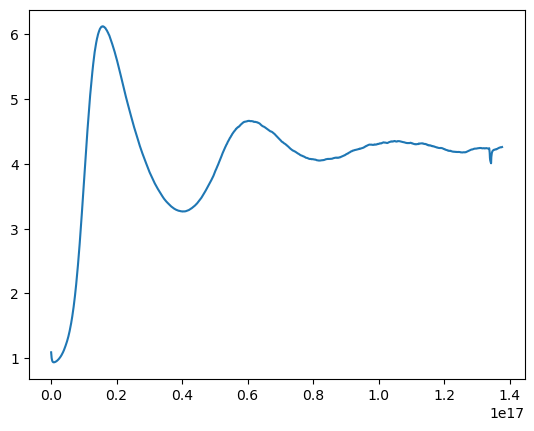

In [11]:
figure()
plot(t,nu)
show()